<a href="https://colab.research.google.com/github/Eleazarrr1979/CNN_LIME_Classification/blob/master/LIME_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and Imports

In [ ]:
%tensorflow_version 1.x
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings
import os, sys
# for resizing images
from PIL import Image

# for image uploader
from google.colab import files

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

TensorFlow 1.x selected.


Using TensorFlow backend.


Notebook running: keras  2.3.1


In [ ]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

In [ ]:
img = files.upload()
os.getcwd()

Saving WhatsApp Image 2020-08-11 at 16.10.49.jpeg to WhatsApp Image 2020-08-11 at 16.10.49 (1).jpeg


'/content'

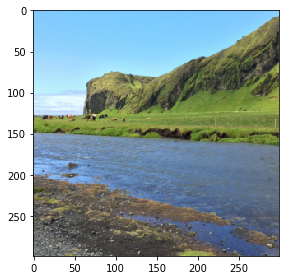

In [ ]:
Xi = skimage.io.imread("/content/WhatsApp Image 2020-08-11 at 16.10.49.jpeg")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

In [ ]:
np.random.seed(222)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)[0] #Top 5 classes


40960/35363 [==================================] - 0s 0us/step


[('n09399592', 'promontory', 0.593139),
 ('n09246464', 'cliff', 0.12366169),
 ('n09421951', 'sandbar', 0.11694886),
 ('n09468604', 'valley', 0.024853112),
 ('n09428293', 'seashore', 0.022714758)]

In [ ]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes 

array([976, 972, 977, 979, 978])

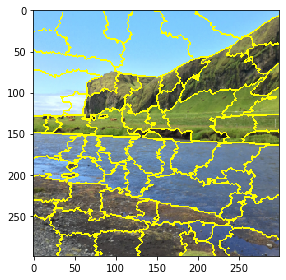

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [ ]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

65

In [ ]:
num_perturb = 1500
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1])

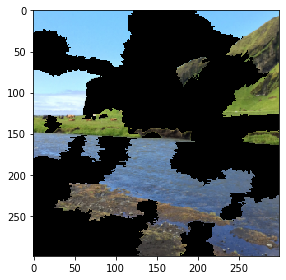

In [ ]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(1500, 1, 1000)

In [ ]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(1500,)

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(1500,)

In [ ]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.00159487,  0.03894564, -0.00138935,  0.01027469,  0.07251409,
        0.0190973 , -0.02967734,  0.00818082, -0.00530741,  0.10012248,
        0.07319268,  0.1009556 ,  0.04474941,  0.03769228,  0.00634319,
       -0.00815184,  0.04245933,  0.00842516,  0.03409616, -0.11329279,
        0.18099858, -0.02779336,  0.01054759,  0.0128448 , -0.03088432,
       -0.01446884, -0.03645626, -0.00321774, -0.01329532, -0.00246898,
       -0.02374807,  0.00315982,  0.03145191,  0.00234969,  0.02437427,
       -0.01306829,  0.00200265, -0.01050634, -0.0022697 , -0.00931529,
        0.01615054,  0.01401464,  0.00845863, -0.01121113,  0.00525609,
        0.00905636,  0.01675811,  0.02740032,  0.02848429,  0.00264337,
        0.00479531, -0.01228093,  0.00206413,  0.01657495, -0.00107495,
        0.00524822,  0.02820901,  0.00082123,  0.00636405,  0.0147729 ,
       -0.00960635, -0.00778331, -0.0095644 ,  0.00290405, -0.00205527])

In [ ]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([10,  9, 11, 20])

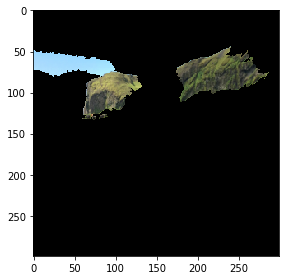

In [ ]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )